In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
seed = 20181122
samples = 500
is_liner = 0 # 0.linear(default), 1.moons, 2.circles
features = 2
if is_liner == 0:
    data, label = make_classification(n_features=features,
                                      n_clusters_per_class=1, 
                                      n_samples=samples,
                                      n_informative=features,
                                      n_redundant=0,
                                      n_repeated=0,
                                      n_classes=2)
#     data, label = make_blobs(n_samples=samples, n_features=features, centers=2, random_state=seed)
elif is_liner == 1:
    data, label = make_moons(n_samples=samples, noise=0.1, random_state=seed) # 月牙形状数据集
elif is_liner == 2:
    data, label = make_circles(n_samples=samples, noise=0.1, factor=0.4, random_state=seed) # 圆形数据集
label = label.reshape((len(label), 1))

In [2]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400, 1), (100, 1))

In [4]:
train = pd.DataFrame(X_train, columns=[f'f{i}' for i in range(features)])
train['label'] = y_train

test = pd.DataFrame(X_test, columns=[f'f{i}' for i in range(features)])
test['label'] = y_test

In [5]:
def plot_graph(df, title=""):
    t = df.query('label == 0')
    x, y = t['f0'].values, t['f1'].values
    plt.scatter(x, y)
    t = df.query('label == 1')
    x, y = t['f0'].values, t['f1'].values
    plt.scatter(x, y)
    plt.legend(['0', '1'])
    plt.title(title)
    plt.show()

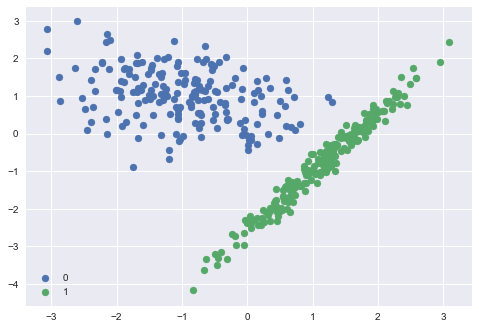

In [6]:
plot_graph(train)

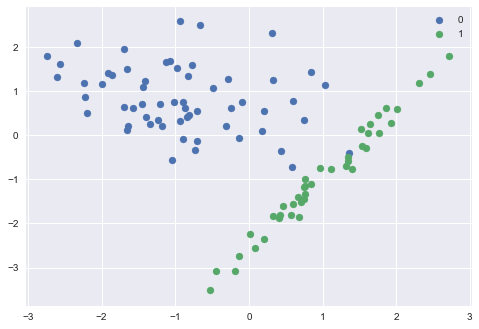

In [7]:
plot_graph(test)

In [8]:
all_data = pd.DataFrame(data, columns=[f'f{i}' for i in range(features)])
all_data['label'] = label

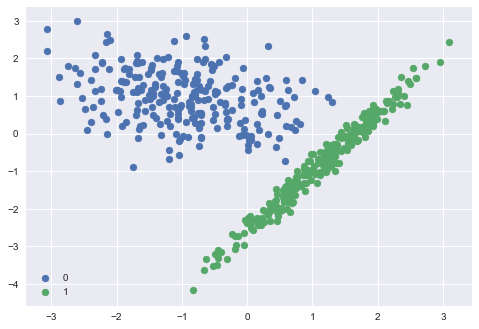

In [9]:
plot_graph(all_data)

In [10]:
# 计算训练集合上的均值 最大值 最小值 用来归一化
mean = np.mean(X_train, axis=0)
maxium = np.max(X_train, axis=0)
minium = np.min(X_train, axis=0)

# 归一化
def normalizition(X, maxium=maxium, minium=minium, mean=mean):
    return (X - mean) / (maxium - minium)

X_train = normalizition(X_train)
X_test = normalizition(X_test)

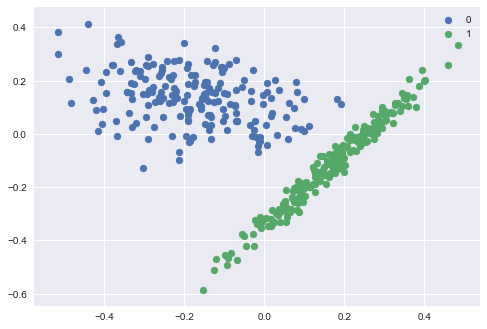

In [11]:
# 下面绘制归一化后的数据集情况
t = pd.DataFrame(X_train, columns=[f'f{i}' for i in range(features)])
t['label'] = y_train
plot_graph(t)

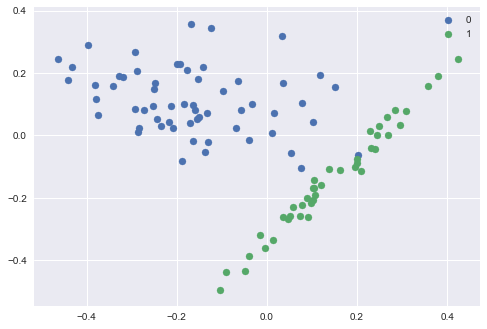

In [12]:
t = pd.DataFrame(X_test, columns=[f'f{i}' for i in range(features)])
t['label'] = y_test
plot_graph(t)

In [13]:
# activation func:sigmoid
def sigmoid(x):
    return 1 / (1+np.exp(-x))
# sigmoid 导数
def sigmoid_prime(x):
    return x * (1 - x)

# activation func:relu
def relu(x):
    return np.maximum(x, 0)
# relu 导数
def relu_prime(z):
    z[z>0]=1
    return z

# activation func: swish
# google提出的一个激活函数，据说比relu好
def swish(x):
    return x * sigmoid(x)
# swish 导数
def swish_prime(x):
    return swish(x) + sigmoid(x) * (1 - swish(x))

# loss function
def binary_crossentropy(label, pred_y):
    return np.mean(-label * np.log(pred_y) - (1 - label) * np.log(1 - pred_y))

# metric
def accuracy(label, pred_y):
    return np.mean(label == (pred_y > 0.5).astype(np.int))

# 激活
def activation(x, acti=sigmoid):
    return acti(x)

# predict
def predict(X, model):
    l1_out = activation(np.dot(X, w0), activati)
    l2_out = activation(np.dot(l1_out, w1), activati)
    pred_y = sigmoid(np.dot(l2_out, w2))
    return pred_y

In [14]:
# 绘制决策边界
def plot_decision_boundary(pred_func, X, y):
    # 设定最大最小值，附加一点点边缘填充
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # 用预测函数预测一下
    # 返回的是概率，转成类别
    try:
        Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    except:
        Z = (pred_func(make_features(np.c_[xx.ravel(), yy.ravel()])))
    Z = (Z > 0.5).astype(np.int)
#     Z = (pred_func(np.c_[xx.ravel(), yy.ravel()]) > 0.5).astype(np.int)
    Z = Z.reshape(xx.shape)
    # 然后画出图
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape((len(y), )), cmap=plt.cm.Spectral)


In [15]:
def get_weights(shape, seed=seed):
    np.random.seed(seed=seed)
    return np.random.normal(size=shape)

In [16]:
# best model
best_model = {"w0":None, 
              "w1":None, 
              "w2":None}
# 早停轮次
stop_epoch = np.inf #300
early_stopping = {"epoch":stop_epoch,
                  "current_epoch":0}
# 最佳得分
best_score = -np.inf
# 最佳epoch
best_epoch = 1
# 迭代次数
epoch = 3000
# 存储loss
cost_train = []
cost_test = []
# metric
train_metric = []
val_metric = []
# 学习率 : 可以更改一下放大或者缩小10倍，看看下面的loss图的变化
alpha = 0.001
# 如果要设置激活函数 请改下面两行代码
# 设置激活函数
activati = relu
# 激活函数的导数
prime = relu_prime
# 初始化权重
# np.random.seed(seed=seed)
nodes = 2
w0 = get_weights(shape=(X_train.shape[1], nodes))
w1 = get_weights(shape=(nodes, nodes))
w2 = get_weights(shape=(nodes, 1))
for i in range(epoch):
    # 正向传播
    l1_out = activation(np.dot(X_train, w0), activati)
    l2_out = activation(np.dot(l1_out, w1), activati)
    pred_y = sigmoid(np.dot(l2_out, w2))
    # 反向传播
#     pred_err = (y_train - pred_y) * (pred_y * (1 - pred_y))
#     l2_to_l1_err = pred_err.dot(w2.T) * (l2_out * (1 - l2_out))
#     l1_to_input_err = l2_to_l1_err.dot(w1.T) * (l1_out * (1 - l1_out))
    pred_err = (y_train - pred_y) * sigmoid_prime(pred_y)# * (1 - pred_y))
    l2_to_l1_err = pred_err.dot(w2.T) * prime(l2_out)
    l1_to_input_err = l2_to_l1_err.dot(w1.T) * prime(l1_out)
    # 根据误差更新权重
    w2 += alpha * l2_out.T.dot(pred_err)
    w1 += alpha * l1_out.T.dot(l2_to_l1_err)
    w0 += alpha * X_train.T.dot(l1_to_input_err)
    model = {"w0":w0, "w1":w1, "w2":w2}
    # 训练集的loss
    cost_train.append(binary_crossentropy(y_train, pred_y))
    test_y = predict(X_test, model)
    cost_test.append(binary_crossentropy(y_test, test_y))
    # 训练集metric
    train_metric.append(accuracy(label=y_train, pred_y=pred_y))
    # 测试集 metric
    score = accuracy(label=y_test, pred_y=test_y)
    val_metric.append(score)
    if score > best_score:
        best_score = score
        best_epoch = i
        best_model['w0'] = w0
        best_model['w1'] = w1
        best_model['w2'] = w2
        early_stopping = {"epoch":stop_epoch,
                          "current_epoch":0}
    
    if early_stopping["epoch"] == early_stopping["current_epoch"]:
        break
    early_stopping["current_epoch"] += 1
#         pass
#     if i % 30 == 0:
    print(f'epoch:{i + 1}',
          'train cost:', cost_train[-1],
          'test cost:', cost_test[-1],
          'train acc:', train_metric[-1], 
          'test acc:', val_metric[-1])    

epoch:1 train cost: 0.571290031409 test cost: 0.641839418253 train acc: 0.4275 test acc: 0.31
epoch:2 train cost: 0.566402007804 test cost: 0.636228722213 train acc: 0.4275 test acc: 0.31
epoch:3 train cost: 0.56172257337 test cost: 0.630826029746 train acc: 0.4275 test acc: 0.31
epoch:4 train cost: 0.557221654558 test cost: 0.625604120517 train acc: 0.43 test acc: 0.32
epoch:5 train cost: 0.55286915482 test cost: 0.620546315942 train acc: 0.4325 test acc: 0.32
epoch:6 train cost: 0.548659171046 test cost: 0.615641511365 train acc: 0.4325 test acc: 0.8
epoch:7 train cost: 0.544583265922 test cost: 0.610873960225 train acc: 0.8375 test acc: 0.8
epoch:8 train cost: 0.540622217732 test cost: 0.606218330116 train acc: 0.84 test acc: 0.8
epoch:9 train cost: 0.536737246433 test cost: 0.601660550298 train acc: 0.8425 test acc: 0.8
epoch:10 train cost: 0.532917684226 test cost: 0.597373419585 train acc: 0.845 test acc: 0.8
epoch:11 train cost: 0.529319946454 test cost: 0.595597747237 train acc

epoch:143 train cost: 0.196084162114 test cost: 0.252268956767 train acc: 0.955 test acc: 0.92
epoch:144 train cost: 0.194892164617 test cost: 0.251027174261 train acc: 0.955 test acc: 0.92
epoch:145 train cost: 0.193725112777 test cost: 0.249808220359 train acc: 0.955 test acc: 0.92
epoch:146 train cost: 0.192582404433 test cost: 0.248611570255 train acc: 0.9575 test acc: 0.92
epoch:147 train cost: 0.19145974831 test cost: 0.247415472139 train acc: 0.9575 test acc: 0.92
epoch:148 train cost: 0.190339513632 test cost: 0.246241188211 train acc: 0.9575 test acc: 0.92
epoch:149 train cost: 0.189242398625 test cost: 0.24508821079 train acc: 0.9575 test acc: 0.92
epoch:150 train cost: 0.188167836959 test cost: 0.24395604285 train acc: 0.9575 test acc: 0.92
epoch:151 train cost: 0.18711527487 test cost: 0.242844198062 train acc: 0.9575 test acc: 0.92
epoch:152 train cost: 0.186084171163 test cost: 0.241752200801 train acc: 0.9575 test acc: 0.92
epoch:153 train cost: 0.185073997178 test cost:

epoch:281 train cost: 0.135044706739 test cost: 0.17759302788 train acc: 0.955 test acc: 0.93
epoch:282 train cost: 0.134910839792 test cost: 0.177372952437 train acc: 0.955 test acc: 0.93
epoch:283 train cost: 0.134778555484 test cost: 0.177154785552 train acc: 0.955 test acc: 0.93
epoch:284 train cost: 0.134647831317 test cost: 0.176938504684 train acc: 0.955 test acc: 0.93
epoch:285 train cost: 0.134518645153 test cost: 0.176724087633 train acc: 0.955 test acc: 0.93
epoch:286 train cost: 0.134390975204 test cost: 0.176511512529 train acc: 0.955 test acc: 0.93
epoch:287 train cost: 0.134264800029 test cost: 0.176300757826 train acc: 0.955 test acc: 0.93
epoch:288 train cost: 0.134140098526 test cost: 0.176091802298 train acc: 0.955 test acc: 0.93
epoch:289 train cost: 0.134016984858 test cost: 0.17588552978 train acc: 0.955 test acc: 0.93
epoch:290 train cost: 0.133895999779 test cost: 0.175680998349 train acc: 0.955 test acc: 0.93
epoch:291 train cost: 0.133776412313 test cost: 0.17

epoch:404 train cost: 0.125389042996 test cost: 0.159844092544 train acc: 0.955 test acc: 0.93
epoch:405 train cost: 0.125335429184 test cost: 0.15973999532 train acc: 0.955 test acc: 0.93
epoch:406 train cost: 0.125282172642 test cost: 0.159636485985 train acc: 0.955 test acc: 0.93
epoch:407 train cost: 0.125229268746 test cost: 0.159533559307 train acc: 0.955 test acc: 0.93
epoch:408 train cost: 0.125176712934 test cost: 0.159431210109 train acc: 0.955 test acc: 0.93
epoch:409 train cost: 0.125124500713 test cost: 0.159329433275 train acc: 0.955 test acc: 0.93
epoch:410 train cost: 0.12507262765 test cost: 0.159228223747 train acc: 0.955 test acc: 0.93
epoch:411 train cost: 0.125021089378 test cost: 0.159127576522 train acc: 0.955 test acc: 0.93
epoch:412 train cost: 0.124969881591 test cost: 0.159027486656 train acc: 0.955 test acc: 0.93
epoch:413 train cost: 0.124919000042 test cost: 0.158927949258 train acc: 0.9575 test acc: 0.93
epoch:414 train cost: 0.124868440549 test cost: 0.1

epoch:506 train cost: 0.121010901417 test cost: 0.151386565901 train acc: 0.96 test acc: 0.94
epoch:507 train cost: 0.12097177926 test cost: 0.151317312636 train acc: 0.96 test acc: 0.94
epoch:508 train cost: 0.120932790774 test cost: 0.151248362816 train acc: 0.96 test acc: 0.94
epoch:509 train cost: 0.120893934805 test cost: 0.151179714424 train acc: 0.96 test acc: 0.94
epoch:510 train cost: 0.120855210223 test cost: 0.151111365464 train acc: 0.96 test acc: 0.94
epoch:511 train cost: 0.12081661591 test cost: 0.151043313958 train acc: 0.96 test acc: 0.94
epoch:512 train cost: 0.12077815077 test cost: 0.150975557948 train acc: 0.96 test acc: 0.94
epoch:513 train cost: 0.120739813723 test cost: 0.150908095496 train acc: 0.96 test acc: 0.94
epoch:514 train cost: 0.120701603706 test cost: 0.15084092468 train acc: 0.96 test acc: 0.94
epoch:515 train cost: 0.120663519671 test cost: 0.1507740436 train acc: 0.96 test acc: 0.94
epoch:516 train cost: 0.120625560591 test cost: 0.150707450372 tra

epoch:620 train cost: 0.116932753491 test cost: 0.144459288213 train acc: 0.9625 test acc: 0.94
epoch:621 train cost: 0.116899355386 test cost: 0.144396214223 train acc: 0.9625 test acc: 0.94
epoch:622 train cost: 0.116866111236 test cost: 0.14433337651 train acc: 0.9625 test acc: 0.94
epoch:623 train cost: 0.116833019854 test cost: 0.14427077383 train acc: 0.9625 test acc: 0.94
epoch:624 train cost: 0.116800080064 test cost: 0.144208404949 train acc: 0.9625 test acc: 0.94
epoch:625 train cost: 0.116767290703 test cost: 0.144146268641 train acc: 0.9625 test acc: 0.94
epoch:626 train cost: 0.116734650618 test cost: 0.144084363688 train acc: 0.9625 test acc: 0.94
epoch:627 train cost: 0.11670215867 test cost: 0.144022688882 train acc: 0.9625 test acc: 0.94
epoch:628 train cost: 0.116669813731 test cost: 0.143961243024 train acc: 0.9625 test acc: 0.94
epoch:629 train cost: 0.116637614684 test cost: 0.143900024923 train acc: 0.9625 test acc: 0.94
epoch:630 train cost: 0.116605560425 test c

epoch:762 train cost: 0.112702071165 test cost: 0.137220651911 train acc: 0.9625 test acc: 0.95
epoch:763 train cost: 0.112681290733 test cost: 0.137181880843 train acc: 0.9625 test acc: 0.95
epoch:764 train cost: 0.112660603888 test cost: 0.137143239821 train acc: 0.9625 test acc: 0.95
epoch:765 train cost: 0.112640009934 test cost: 0.13710472819 train acc: 0.9625 test acc: 0.95
epoch:766 train cost: 0.112619508181 test cost: 0.137066345298 train acc: 0.9625 test acc: 0.95
epoch:767 train cost: 0.112599097946 test cost: 0.137028090499 train acc: 0.9625 test acc: 0.95
epoch:768 train cost: 0.112578778555 test cost: 0.13698996315 train acc: 0.9625 test acc: 0.95
epoch:769 train cost: 0.112558549337 test cost: 0.136951962614 train acc: 0.9625 test acc: 0.95
epoch:770 train cost: 0.112538409628 test cost: 0.136914088256 train acc: 0.9625 test acc: 0.95
epoch:771 train cost: 0.112518358773 test cost: 0.136876339449 train acc: 0.9625 test acc: 0.95
epoch:772 train cost: 0.11249839612 test c

epoch:899 train cost: 0.110507981485 test cost: 0.132902325253 train acc: 0.9625 test acc: 0.95
epoch:900 train cost: 0.110495582807 test cost: 0.132876908881 train acc: 0.9625 test acc: 0.95
epoch:901 train cost: 0.110483222999 test cost: 0.132851561348 train acc: 0.9625 test acc: 0.95
epoch:902 train cost: 0.110470901849 test cost: 0.132826282376 train acc: 0.9625 test acc: 0.95
epoch:903 train cost: 0.110458619149 test cost: 0.132801071689 train acc: 0.9625 test acc: 0.95
epoch:904 train cost: 0.110446374691 test cost: 0.132775929012 train acc: 0.9625 test acc: 0.95
epoch:905 train cost: 0.110434168271 test cost: 0.132750854071 train acc: 0.9625 test acc: 0.95
epoch:906 train cost: 0.110421999684 test cost: 0.132725846596 train acc: 0.9625 test acc: 0.95
epoch:907 train cost: 0.110409868728 test cost: 0.132700906316 train acc: 0.9625 test acc: 0.95
epoch:908 train cost: 0.110397775202 test cost: 0.132676032962 train acc: 0.9625 test acc: 0.95
epoch:909 train cost: 0.110385718907 tes

epoch:1015 train cost: 0.109285344475 test cost: 0.130322143369 train acc: 0.9625 test acc: 0.95
epoch:1016 train cost: 0.109276377827 test cost: 0.130302681426 train acc: 0.9625 test acc: 0.95
epoch:1017 train cost: 0.109267433581 test cost: 0.130283264487 train acc: 0.9625 test acc: 0.95
epoch:1018 train cost: 0.109258511643 test cost: 0.130263892393 train acc: 0.9625 test acc: 0.95
epoch:1019 train cost: 0.109249611923 test cost: 0.130244564989 train acc: 0.9625 test acc: 0.95
epoch:1020 train cost: 0.109240734327 test cost: 0.130225282118 train acc: 0.9625 test acc: 0.95
epoch:1021 train cost: 0.109231878766 test cost: 0.130206043626 train acc: 0.9625 test acc: 0.95
epoch:1022 train cost: 0.109223045149 test cost: 0.130186849357 train acc: 0.9625 test acc: 0.95
epoch:1023 train cost: 0.109214233385 test cost: 0.130167699158 train acc: 0.9625 test acc: 0.95
epoch:1024 train cost: 0.109205443387 test cost: 0.130148592876 train acc: 0.9625 test acc: 0.95
epoch:1025 train cost: 0.10919

epoch:1140 train cost: 0.108744835871 test cost: 0.128437394501 train acc: 0.96 test acc: 0.95
epoch:1141 train cost: 0.108750274977 test cost: 0.128429175807 train acc: 0.96 test acc: 0.95
epoch:1142 train cost: 0.108755600713 test cost: 0.128420919628 train acc: 0.96 test acc: 0.95
epoch:1143 train cost: 0.108760814321 test cost: 0.128412626521 train acc: 0.96 test acc: 0.95
epoch:1144 train cost: 0.108765917031 test cost: 0.128404297042 train acc: 0.96 test acc: 0.95
epoch:1145 train cost: 0.108770910061 test cost: 0.128395931739 train acc: 0.96 test acc: 0.95
epoch:1146 train cost: 0.108775794621 test cost: 0.128387531157 train acc: 0.96 test acc: 0.95
epoch:1147 train cost: 0.108780571907 test cost: 0.128379095833 train acc: 0.96 test acc: 0.95
epoch:1148 train cost: 0.108785243104 test cost: 0.128370626304 train acc: 0.96 test acc: 0.95
epoch:1149 train cost: 0.108789809389 test cost: 0.128362123098 train acc: 0.96 test acc: 0.95
epoch:1150 train cost: 0.108794271924 test cost: 0

epoch:1289 train cost: 0.110637586566 test cost: 0.12805230211 train acc: 0.96 test acc: 0.95
epoch:1290 train cost: 0.110641720048 test cost: 0.128046300751 train acc: 0.96 test acc: 0.95
epoch:1291 train cost: 0.110645482184 test cost: 0.128040114993 train acc: 0.96 test acc: 0.95
epoch:1292 train cost: 0.110648887692 test cost: 0.128033752611 train acc: 0.96 test acc: 0.95
epoch:1293 train cost: 0.110651950741 test cost: 0.128027221091 train acc: 0.96 test acc: 0.95
epoch:1294 train cost: 0.110654684972 test cost: 0.128020527641 train acc: 0.96 test acc: 0.95
epoch:1295 train cost: 0.110657103511 test cost: 0.128013679199 train acc: 0.96 test acc: 0.95
epoch:1296 train cost: 0.110659218993 test cost: 0.128006682443 train acc: 0.96 test acc: 0.95
epoch:1297 train cost: 0.110661043574 test cost: 0.1279995438 train acc: 0.96 test acc: 0.95
epoch:1298 train cost: 0.110662588951 test cost: 0.127992269453 train acc: 0.96 test acc: 0.95
epoch:1299 train cost: 0.110663866379 test cost: 0.12

epoch:1418 train cost: 0.110042746721 test cost: 0.126774174468 train acc: 0.96 test acc: 0.96
epoch:1419 train cost: 0.110037622621 test cost: 0.126764769441 train acc: 0.96 test acc: 0.96
epoch:1420 train cost: 0.110032543324 test cost: 0.126755397768 train acc: 0.96 test acc: 0.96
epoch:1421 train cost: 0.110027507179 test cost: 0.126746058543 train acc: 0.96 test acc: 0.96
epoch:1422 train cost: 0.110022512603 test cost: 0.126736750898 train acc: 0.96 test acc: 0.96
epoch:1423 train cost: 0.110017558079 test cost: 0.126727473999 train acc: 0.96 test acc: 0.96
epoch:1424 train cost: 0.110012642153 test cost: 0.126718227047 train acc: 0.96 test acc: 0.96
epoch:1425 train cost: 0.11000776343 test cost: 0.126709009274 train acc: 0.96 test acc: 0.96
epoch:1426 train cost: 0.110002920573 test cost: 0.126699819943 train acc: 0.96 test acc: 0.96
epoch:1427 train cost: 0.109998112301 test cost: 0.126690658348 train acc: 0.96 test acc: 0.96
epoch:1428 train cost: 0.109993337386 test cost: 0.

epoch:1567 train cost: 0.109452610121 test cost: 0.125558368085 train acc: 0.96 test acc: 0.96
epoch:1568 train cost: 0.109449146365 test cost: 0.125551039224 train acc: 0.96 test acc: 0.96
epoch:1569 train cost: 0.109445686907 test cost: 0.125543719398 train acc: 0.96 test acc: 0.96
epoch:1570 train cost: 0.109442231737 test cost: 0.125536408589 train acc: 0.96 test acc: 0.96
epoch:1571 train cost: 0.109438780844 test cost: 0.125529106776 train acc: 0.96 test acc: 0.96
epoch:1572 train cost: 0.109435334218 test cost: 0.125521813938 train acc: 0.96 test acc: 0.96
epoch:1573 train cost: 0.109431891847 test cost: 0.125514530058 train acc: 0.96 test acc: 0.96
epoch:1574 train cost: 0.109428453722 test cost: 0.125507255115 train acc: 0.96 test acc: 0.96
epoch:1575 train cost: 0.109425019833 test cost: 0.125499989091 train acc: 0.96 test acc: 0.96
epoch:1576 train cost: 0.109421590169 test cost: 0.125492731965 train acc: 0.96 test acc: 0.96
epoch:1577 train cost: 0.10941816472 test cost: 0.

epoch:1705 train cost: 0.109011571449 test cost: 0.124624944294 train acc: 0.96 test acc: 0.96
epoch:1706 train cost: 0.10900862389 test cost: 0.124618703873 train acc: 0.96 test acc: 0.96
epoch:1707 train cost: 0.109005679602 test cost: 0.124612470333 train acc: 0.96 test acc: 0.96
epoch:1708 train cost: 0.109002738579 test cost: 0.12460624366 train acc: 0.96 test acc: 0.96
epoch:1709 train cost: 0.108999800816 test cost: 0.124600023841 train acc: 0.96 test acc: 0.96
epoch:1710 train cost: 0.108996866307 test cost: 0.124593810864 train acc: 0.96 test acc: 0.96
epoch:1711 train cost: 0.108993935045 test cost: 0.124587604717 train acc: 0.96 test acc: 0.96
epoch:1712 train cost: 0.108991007025 test cost: 0.124581405387 train acc: 0.96 test acc: 0.96
epoch:1713 train cost: 0.108988082241 test cost: 0.124575212861 train acc: 0.96 test acc: 0.96
epoch:1714 train cost: 0.108985160688 test cost: 0.124569027127 train acc: 0.96 test acc: 0.96
epoch:1715 train cost: 0.108982242359 test cost: 0.1

epoch:1855 train cost: 0.108603038442 test cost: 0.123759421438 train acc: 0.96 test acc: 0.96
epoch:1856 train cost: 0.108600523417 test cost: 0.123754088405 train acc: 0.96 test acc: 0.96
epoch:1857 train cost: 0.108598010927 test cost: 0.123748760682 train acc: 0.96 test acc: 0.96
epoch:1858 train cost: 0.108595500969 test cost: 0.123743438259 train acc: 0.96 test acc: 0.96
epoch:1859 train cost: 0.108592993538 test cost: 0.123738121128 train acc: 0.96 test acc: 0.96
epoch:1860 train cost: 0.10859048863 test cost: 0.123732809281 train acc: 0.96 test acc: 0.96
epoch:1861 train cost: 0.108587986241 test cost: 0.123727502708 train acc: 0.96 test acc: 0.96
epoch:1862 train cost: 0.108585486367 test cost: 0.123722201401 train acc: 0.96 test acc: 0.96
epoch:1863 train cost: 0.108582989004 test cost: 0.123716905352 train acc: 0.96 test acc: 0.96
epoch:1864 train cost: 0.108580494149 test cost: 0.123711614553 train acc: 0.96 test acc: 0.96
epoch:1865 train cost: 0.108578001796 test cost: 0.

epoch:1960 train cost: 0.108352081571 test cost: 0.123226923101 train acc: 0.96 test acc: 0.96
epoch:1961 train cost: 0.108349812117 test cost: 0.123222104223 train acc: 0.96 test acc: 0.96
epoch:1962 train cost: 0.108347544817 test cost: 0.123217289855 train acc: 0.96 test acc: 0.96
epoch:1963 train cost: 0.108345279666 test cost: 0.12321247999 train acc: 0.96 test acc: 0.96
epoch:1964 train cost: 0.108343016662 test cost: 0.123207674621 train acc: 0.96 test acc: 0.96
epoch:1965 train cost: 0.108340755802 test cost: 0.123202873743 train acc: 0.96 test acc: 0.96
epoch:1966 train cost: 0.108338497082 test cost: 0.123198077347 train acc: 0.96 test acc: 0.96
epoch:1967 train cost: 0.108336240499 test cost: 0.123193285428 train acc: 0.96 test acc: 0.96
epoch:1968 train cost: 0.10833398605 test cost: 0.123188497979 train acc: 0.96 test acc: 0.96
epoch:1969 train cost: 0.108331733732 test cost: 0.123183714993 train acc: 0.96 test acc: 0.96
epoch:1970 train cost: 0.108329483541 test cost: 0.1

epoch:2077 train cost: 0.108100373986 test cost: 0.122692081144 train acc: 0.96 test acc: 0.96
epoch:2078 train cost: 0.108098336171 test cost: 0.122687748108 train acc: 0.96 test acc: 0.96
epoch:2079 train cost: 0.108096300172 test cost: 0.122683418892 train acc: 0.96 test acc: 0.96
epoch:2080 train cost: 0.108094265988 test cost: 0.122679093489 train acc: 0.96 test acc: 0.96
epoch:2081 train cost: 0.108092233616 test cost: 0.122674771895 train acc: 0.96 test acc: 0.96
epoch:2082 train cost: 0.108090203054 test cost: 0.122670454104 train acc: 0.96 test acc: 0.96
epoch:2083 train cost: 0.108088174298 test cost: 0.122666140112 train acc: 0.96 test acc: 0.96
epoch:2084 train cost: 0.108086147347 test cost: 0.122661829912 train acc: 0.96 test acc: 0.96
epoch:2085 train cost: 0.108084122197 test cost: 0.122657523501 train acc: 0.96 test acc: 0.96
epoch:2086 train cost: 0.108082098847 test cost: 0.122653220873 train acc: 0.96 test acc: 0.96
epoch:2087 train cost: 0.108080077293 test cost: 0

epoch:2184 train cost: 0.107962619212 test cost: 0.122289357123 train acc: 0.96 test acc: 0.96
epoch:2185 train cost: 0.107963898207 test cost: 0.122283010685 train acc: 0.96 test acc: 0.96
epoch:2186 train cost: 0.107957803685 test cost: 0.122280832018 train acc: 0.96 test acc: 0.96
epoch:2187 train cost: 0.107959139941 test cost: 0.122278551371 train acc: 0.96 test acc: 0.96
epoch:2188 train cost: 0.107960293238 test cost: 0.122272148141 train acc: 0.96 test acc: 0.96
epoch:2189 train cost: 0.107954084283 test cost: 0.122269913387 train acc: 0.96 test acc: 0.96
epoch:2190 train cost: 0.107955308894 test cost: 0.122263556114 train acc: 0.96 test acc: 0.96
epoch:2191 train cost: 0.107949173804 test cost: 0.122261362821 train acc: 0.96 test acc: 0.96
epoch:2192 train cost: 0.107950462173 test cost: 0.12225906916 train acc: 0.96 test acc: 0.96
epoch:2193 train cost: 0.107951570272 test cost: 0.122252660002 train acc: 0.96 test acc: 0.96
epoch:2194 train cost: 0.107945329615 test cost: 0.

epoch:2287 train cost: 0.107790924302 test cost: 0.121903007627 train acc: 0.96 test acc: 0.96
epoch:2288 train cost: 0.107791255866 test cost: 0.121896512001 train acc: 0.96 test acc: 0.96
epoch:2289 train cost: 0.107784480611 test cost: 0.121894104544 train acc: 0.96 test acc: 0.96
epoch:2290 train cost: 0.107784985314 test cost: 0.1218916241 train acc: 0.96 test acc: 0.96
epoch:2291 train cost: 0.107785357004 test cost: 0.121889075078 train acc: 0.96 test acc: 0.96
epoch:2292 train cost: 0.10778560449 test cost: 0.121882547418 train acc: 0.96 test acc: 0.96
epoch:2293 train cost: 0.10777875688 test cost: 0.121880106568 train acc: 0.96 test acc: 0.96
epoch:2294 train cost: 0.107779186982 test cost: 0.121877595284 train acc: 0.96 test acc: 0.96
epoch:2295 train cost: 0.107779488683 test cost: 0.121871106844 train acc: 0.96 test acc: 0.96
epoch:2296 train cost: 0.107772699939 test cost: 0.12186870034 train acc: 0.96 test acc: 0.96
epoch:2297 train cost: 0.107773179212 test cost: 0.1218

epoch:2402 train cost: 0.107610894556 test cost: 0.121505357463 train acc: 0.96 test acc: 0.96
epoch:2403 train cost: 0.107610447785 test cost: 0.121502607009 train acc: 0.96 test acc: 0.96
epoch:2404 train cost: 0.107609930285 test cost: 0.121499820918 train acc: 0.96 test acc: 0.96
epoch:2405 train cost: 0.107609346528 test cost: 0.121493201341 train acc: 0.96 test acc: 0.96
epoch:2406 train cost: 0.107601935167 test cost: 0.121490584457 train acc: 0.96 test acc: 0.96
epoch:2407 train cost: 0.107601643476 test cost: 0.121487924307 train acc: 0.96 test acc: 0.96
epoch:2408 train cost: 0.107601271912 test cost: 0.121485223649 train acc: 0.96 test acc: 0.96
epoch:2409 train cost: 0.107600825357 test cost: 0.121482485077 train acc: 0.96 test acc: 0.96
epoch:2410 train cost: 0.107600308401 test cost: 0.121479711031 train acc: 0.96 test acc: 0.96
epoch:2411 train cost: 0.107599725359 test cost: 0.121476903803 train acc: 0.96 test acc: 0.96
epoch:2412 train cost: 0.107599080464 test cost: 0

epoch:2507 train cost: 0.107458977952 test cost: 0.121171425852 train acc: 0.96 test acc: 0.96
epoch:2508 train cost: 0.107457881164 test cost: 0.121168526025 train acc: 0.96 test acc: 0.96
epoch:2509 train cost: 0.107456759788 test cost: 0.121165614912 train acc: 0.96 test acc: 0.96
epoch:2510 train cost: 0.107455615417 test cost: 0.121162693357 train acc: 0.96 test acc: 0.96
epoch:2511 train cost: 0.107454449547 test cost: 0.121159762153 train acc: 0.96 test acc: 0.96
epoch:2512 train cost: 0.10745326358 test cost: 0.121156822044 train acc: 0.96 test acc: 0.96
epoch:2513 train cost: 0.107452058831 test cost: 0.121153873725 train acc: 0.96 test acc: 0.96
epoch:2514 train cost: 0.107450836536 test cost: 0.121150917853 train acc: 0.96 test acc: 0.96
epoch:2515 train cost: 0.107449597851 test cost: 0.121147955039 train acc: 0.96 test acc: 0.96
epoch:2516 train cost: 0.107448343865 test cost: 0.121144985861 train acc: 0.96 test acc: 0.96
epoch:2517 train cost: 0.107447075596 test cost: 0.

epoch:2630 train cost: 0.10728805191 test cost: 0.120808425467 train acc: 0.96 test acc: 0.96
epoch:2631 train cost: 0.107286673582 test cost: 0.120805582015 train acc: 0.96 test acc: 0.96
epoch:2632 train cost: 0.107285296245 test cost: 0.120802740667 train acc: 0.96 test acc: 0.96
epoch:2633 train cost: 0.107283919899 test cost: 0.12079990142 train acc: 0.96 test acc: 0.96
epoch:2634 train cost: 0.107282544543 test cost: 0.120797064273 train acc: 0.96 test acc: 0.96
epoch:2635 train cost: 0.107281170177 test cost: 0.120794229225 train acc: 0.96 test acc: 0.96
epoch:2636 train cost: 0.107279796799 test cost: 0.120791396272 train acc: 0.96 test acc: 0.96
epoch:2637 train cost: 0.107278424409 test cost: 0.120788565415 train acc: 0.96 test acc: 0.96
epoch:2638 train cost: 0.107277053007 test cost: 0.120785736649 train acc: 0.96 test acc: 0.96
epoch:2639 train cost: 0.107275682591 test cost: 0.120782909975 train acc: 0.96 test acc: 0.96
epoch:2640 train cost: 0.107274313161 test cost: 0.1

epoch:2759 train cost: 0.107118115975 test cost: 0.120458330417 train acc: 0.96 test acc: 0.96
epoch:2760 train cost: 0.107116857864 test cost: 0.120455742887 train acc: 0.96 test acc: 0.96
epoch:2761 train cost: 0.107115600622 test cost: 0.120453157224 train acc: 0.96 test acc: 0.96
epoch:2762 train cost: 0.107114344248 test cost: 0.120450573426 train acc: 0.96 test acc: 0.96
epoch:2763 train cost: 0.107113088741 test cost: 0.120447991491 train acc: 0.96 test acc: 0.96
epoch:2764 train cost: 0.107111834101 test cost: 0.120445411417 train acc: 0.96 test acc: 0.96
epoch:2765 train cost: 0.107110580327 test cost: 0.120442833204 train acc: 0.96 test acc: 0.96
epoch:2766 train cost: 0.107109327417 test cost: 0.120440256848 train acc: 0.96 test acc: 0.96
epoch:2767 train cost: 0.107108075371 test cost: 0.120437682349 train acc: 0.96 test acc: 0.96
epoch:2768 train cost: 0.107106824187 test cost: 0.120435109705 train acc: 0.96 test acc: 0.96
epoch:2769 train cost: 0.107105573865 test cost: 0

epoch:2863 train cost: 0.106991765803 test cost: 0.120198925669 train acc: 0.96 test acc: 0.96
epoch:2864 train cost: 0.10699059338 test cost: 0.120196523569 train acc: 0.96 test acc: 0.96
epoch:2865 train cost: 0.106989421738 test cost: 0.120194123171 train acc: 0.96 test acc: 0.96
epoch:2866 train cost: 0.106988250874 test cost: 0.120191724473 train acc: 0.96 test acc: 0.96
epoch:2867 train cost: 0.106987080789 test cost: 0.120189327474 train acc: 0.96 test acc: 0.96
epoch:2868 train cost: 0.106985911482 test cost: 0.120186932172 train acc: 0.96 test acc: 0.96
epoch:2869 train cost: 0.106984742951 test cost: 0.120184538565 train acc: 0.96 test acc: 0.96
epoch:2870 train cost: 0.106983575196 test cost: 0.120182146653 train acc: 0.96 test acc: 0.96
epoch:2871 train cost: 0.106982408217 test cost: 0.120179756434 train acc: 0.96 test acc: 0.96
epoch:2872 train cost: 0.106981242012 test cost: 0.120177367906 train acc: 0.96 test acc: 0.96
epoch:2873 train cost: 0.10698007658 test cost: 0.1

epoch:2964 train cost: 0.106877161239 test cost: 0.119964668211 train acc: 0.96 test acc: 0.96
epoch:2965 train cost: 0.106876063735 test cost: 0.119962430822 train acc: 0.96 test acc: 0.96
epoch:2966 train cost: 0.106874966937 test cost: 0.119960194993 train acc: 0.96 test acc: 0.96
epoch:2967 train cost: 0.106873870842 test cost: 0.119957960725 train acc: 0.96 test acc: 0.96
epoch:2968 train cost: 0.10687277545 test cost: 0.119955728016 train acc: 0.96 test acc: 0.96
epoch:2969 train cost: 0.106871680761 test cost: 0.119953496865 train acc: 0.96 test acc: 0.96
epoch:2970 train cost: 0.106870586773 test cost: 0.11995126727 train acc: 0.96 test acc: 0.96
epoch:2971 train cost: 0.106869493487 test cost: 0.11994903923 train acc: 0.96 test acc: 0.96
epoch:2972 train cost: 0.106868400901 test cost: 0.119946812744 train acc: 0.96 test acc: 0.96
epoch:2973 train cost: 0.106867309014 test cost: 0.11994458781 train acc: 0.96 test acc: 0.96
epoch:2974 train cost: 0.106866217827 test cost: 0.119

In [17]:
f"best_epoch:{best_epoch}, best_score:{best_score}"

'best_epoch:1320, best_score:0.96'

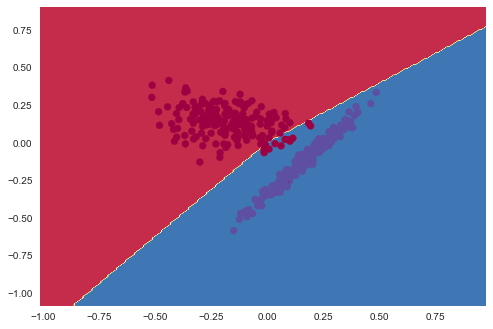

In [18]:
# 绘制训练集合的决策边界
# if features == 2:
plot_decision_boundary(pred_func=lambda x : predict(x, best_model), X=X_train, y=y_train)
plt.show()

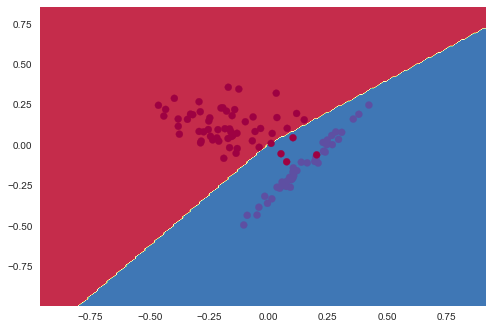

In [19]:
# 绘制测试集的决策边界
# if features == 2:
plot_decision_boundary(pred_func=lambda x : predict(x, best_model), X=X_test, y=y_test)
plt.show()

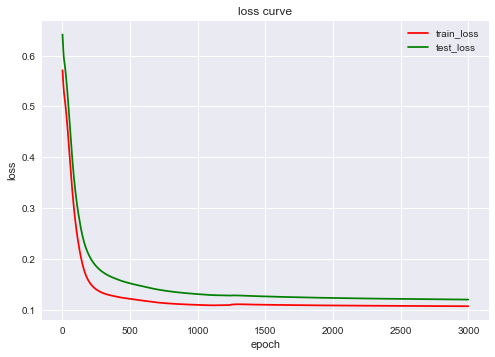

In [20]:
# loss曲线
plt.plot(list(range(len(cost_train))), cost_train, color='r')
plt.plot(list(range(len(cost_test))), cost_test, color='g')
plt.legend(['train_loss', 'test_loss'])
plt.title('loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

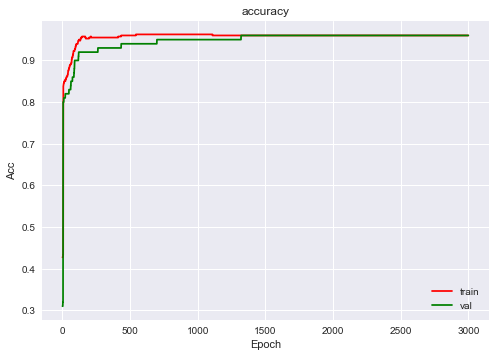

In [21]:
# metric 曲线
plt.plot(list(range(len(train_metric))), train_metric, color='r')
plt.plot(list(range(len(val_metric))), val_metric, color='g')
plt.legend(['train', 'val'])
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()

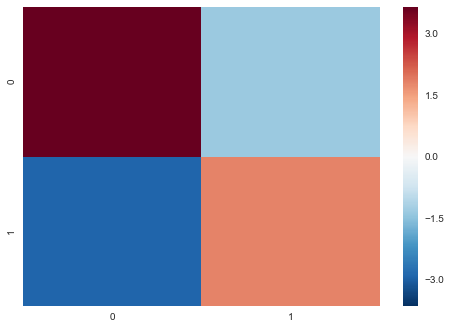

In [22]:
# w0权重
sns.heatmap(best_model['w0'])
plt.show()

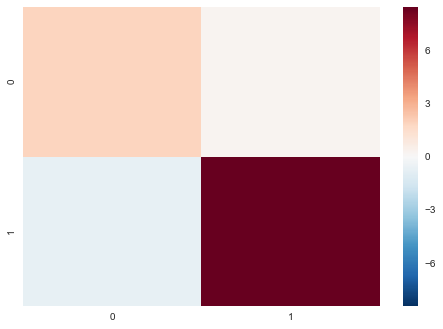

In [23]:
# w1 权重
sns.heatmap(best_model['w1'])
plt.show()

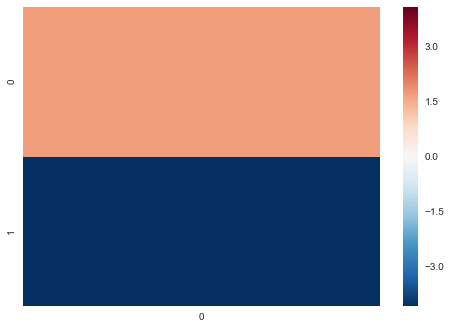

In [24]:
# w2权重
sns.heatmap(best_model['w2'])
plt.show()

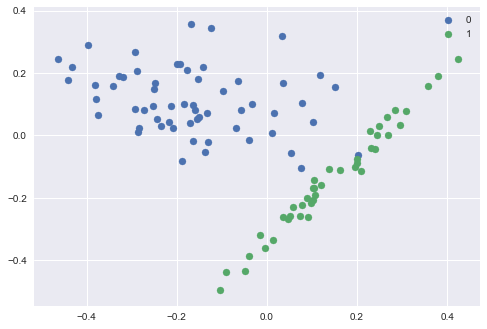

In [25]:
test = pd.DataFrame(X_test, columns=['f0', 'f1'])
test['label'] = y_test
plot_graph(test)

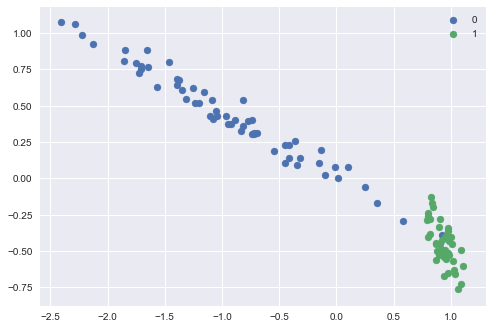

In [26]:
test_w0 = pd.DataFrame(test[['f0', 'f1']].values.dot(best_model['w0']), columns=['f0', 'f1'])
test_w0['label'] = y_test
plot_graph(test_w0)

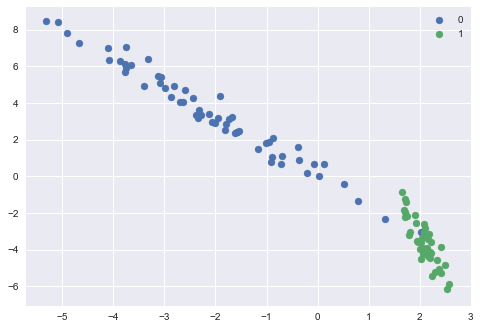

In [27]:
test_w1 = pd.DataFrame(test_w0[['f0', 'f1']].values.dot(best_model['w1']), columns=['f0', 'f1'])
test_w1['label'] = y_test
plot_graph(test_w1)

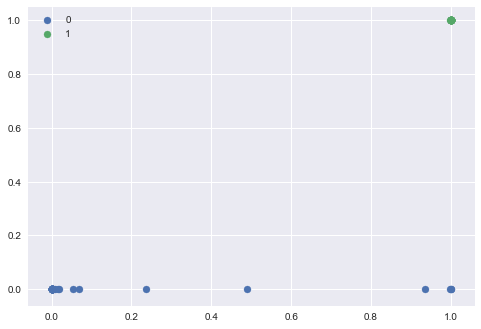

In [28]:
test_w2 = pd.DataFrame(sigmoid(test_w1[['f0', 'f1']].values.dot(best_model['w2'])), columns=['f0'])
test_w2['f1'] = y_test
test_w2['label'] = y_test
plot_graph(test_w2)